This script estimates the performance of naive bayes classification in a document-topic model's feature space

In [1]:
%load_ext autoreload
%autoreload 2
import time
start_time = time.time()

import json
import numpy as np
import csv

import sys
sys.path.append("../libraries/")
from selector import split_data

In [724]:
# searches for first match to target in dat, beginning
# search at start_offset
# useful for searching sorted lists.
def linearSearch(dat, target, start_offset=0):
    for i in range(start_offset, len(dat)):
        if target == dat[i]:
            return i
    

# takes n x 1 vectors of prsn_ratings and matching prsn_id,
# and an m x 1 (n >= m) vector of uniq_prsn_ids for whom we
# want to get average X. Does not preserve order.
# returns new uniq_lbls corresponding to order of avg_X
# O( n log(n) )
#
# if laplaceSmoothing is used then we add alpha to numerator
# and alpha*d to the denominator. If empirical distribution
# is known you can specify empirical distribution of category
# using mu. Mu can be a vector of length m if X is n x m
def avgByLbl(X, lbls):    
    # sort data for efficient averaging
    dat = sorted(list(zip(X,lbls)), key=lambda id: id[1])
    dat = [[i for i,j in dat], [j for i,j in dat]]
    X = np.array(dat[0])
    lbls = dat[1]
    
    uniq_lbls = np.unique(lbls)
    uniq_lbls = sorted(uniq_lbls)
    
    # use an averaging algorithm optimized for sorted entries
    # (requires sorted search targets and search list)
    # this algorithm never traverses the same element of the
    # search list twice, but carries the overhead of a pre-
    # sorted target list and search list. Thankfully those
    # can use the O(n log(n)) python sort implementation
    idx = 0
    
    if len(X.shape) > 1:
        avg_X = np.zeros((len(uniq_lbls),len(X[0])))
        for i,this_id in enumerate(uniq_lbls):
            idx = linearSearch(lbls, this_id, idx)
            n = 0.0
            while idx < len(lbls) and lbls[idx] == this_id:
                avg_X[i] = np.sum(np.vstack([avg_X[i],X[idx]]),axis=0)
                n += 1.0
                idx += 1
            avg_X[i] /= n
    else: 
        avg_X = np.zeros(len(uniq_lbls))
        for i,this_id in enumerate(uniq_lbls):
            idx = linearSearch(lbls, this_id, idx)
            n = 0.0
            while idx < len(lbls) and lbls[idx] == this_id:
                avg_X[i] += X[idx]
                n += 1.0
                idx += 1
            avg_X[i] /= n
            
    return avg_X, uniq_lbls

In [698]:
from sklearn.base import TransformerMixin, BaseEstimator


# computes a profile for each subject specifying their likelihood of
# submitting a particular rating. Transforms features (subject identifiers)
# into a feature vector of log likelihoods representing the likelihood
# of a particular rating given the identity of the subject providing the
# rating
class subjLogLikProfiles(TransformerMixin, BaseEstimator):
    
    def _sumByLbl(self, X, lbls, laplaceSmooth=None):
        # precomute any smoothing factors (SF)
        if laplaceSmooth is not None:
            numSF = np.multiply(laplaceSmooth['alpha']*laplaceSmooth['d'], laplaceSmooth['mu'])
            denSF = laplaceSmooth['alpha']*laplaceSmooth['d']
        else:
            numSF = 0
            denSF = 0

        # sort data for efficient averaging
        dat = sorted(list(zip(X,lbls)), key=lambda id: id[1])
        dat = [[i for i,j in dat], [j for i,j in dat]]
        X = np.array(dat[0])
        lbls = dat[1]

        uniq_lbls = np.unique(lbls)
        uniq_lbls = sorted(uniq_lbls)

        # use an averaging algorithm optimized for sorted entries
        # (requires sorted search targets and search list)
        # this algorithm never traverses the same element of the
        # search list twice, but carries the overhead of a pre-
        # sorted target list and search list. Thankfully those
        # can use the O(n log(n)) python sort implementation
        idx = 0
        cum_X = np.zeros((len(uniq_lbls),len(X[0])))
        
        for i,this_id in enumerate(uniq_lbls):
            idx = linearSearch(lbls, this_id, idx)
            n = 0.0
            while idx < len(lbls) and lbls[idx] == this_id:
                cum_X[i] = np.sum(np.vstack([cum_X[i],X[idx]]),axis=0)
                n += 1.0
                idx += 1
            cum_X[i] += numSF
            cum_X[i] *= n/(n + denSF)

        return cum_X, uniq_lbls
    
    # asumes X is tuple (prsn_id, prsn_rating, prod_id)
    def __init__(self, laplaceSmooth=None):
        self.laplaceSmooth = laplaceSmooth
    
    def fit(self, X, y):
        yLbl = np.unique(y)
        
        # mu is 'empirical' estimate it from empirical incidences
        if self.laplaceSmooth:
            if type(self.laplaceSmooth['mu']) is str and self.laplaceSmooth['mu'] == 'empirical':
                mu = np.zeros(self.laplaceSmooth['d'])
                for i in range(0, self.laplaceSmooth['d']):
                    mu[i] = np.mean(y == yLbl[i])
                
                self.laplaceSmooth['mu'] = mu
                
            if type(self.laplaceSmooth['mu']) is str and self.laplaceSmooth['mu'] == 'uniform':
                self.laplaceSmooth['mu'] = [1.0/self.laplaceSmooth['d']]*self.laplaceSmooth['d']
        
        # return frequencies of each review label for this subject
        yExp = [y==yLbl[0]]
        for i in range(1,len(yLbl)):
            yExp = np.vstack([yExp, [y==yLbl[i]]])
        yExp = np.transpose(yExp)
                
        subjectClassIncidence, uniq_prsn_id = self._sumByLbl(yExp, X, self.laplaceSmooth)
        
        classIncidence = np.sum(yExp,axis=0)
        classIncidence = np.tile(classIncidence, len(subjectClassIncidence)
                                ).reshape(len(subjectClassIncidence),len(classIncidence))
        
        logLik = np.subtract(np.log(subjectClassIncidence), np.log(classIncidence))
        
        self.profile = dict(zip(uniq_prsn_id, logLik))
        
        return self
        
    def transform(self, X):
        meanValue = np.mean(np.array(list(self.profile.values())), axis=0)
        
        profile = [meanValue]*len(X)
        for i, rid in enumerate(X):
            if rid in self.profile:
                profile[i] = self.profile[rid]
        
        profile = np.vstack(profile)
        
        return profile
    
# converts likelihoods to posterior probabilities using a uniform prior
class logLik2PostProb(TransformerMixin, BaseEstimator):
    
    def fit(self,X,y):
        return self
    
    def transform(self,X,y=None):
        marginal = np.log(np.sum(np.exp(X), axis=1))
        n, m = np.shape(X)
        marginal = np.transpose(np.tile(marginal, m).reshape(m,n))
        
        return np.exp(np.subtract(X, marginal))

In [4]:
import pandas as pd

t0 = time.time()

prsn_asin = []
prsn_id = []
prsn_rating = []
with open('../data/Sports_and_Outdoors_Ratings_training.csv') as file:
    reader = pd.read_csv(file, delimiter=',')
    prsn_rating = np.array([item[1] for item in reader['overall'].items()])
    prsn_id = np.array([item[1] for item in reader['reviewerID'].items()])
    prsn_asin = np.array([item[1] for item in reader['asin'].items()])

t1 = time.time()
print(t1-t0)

20.205960988998413


In [739]:
X = prsn_id
y = prsn_rating
lbl = prsn_asin

In [642]:
# predict expected rating for each review

t0 = time.time()

# GroupKFold gives you a KFold partitioner that abides by
# product labels so that products are only ever in a single
# fold
gkf = GroupKFold(n_splits=5)
cv = gkf.split(X, y, groups=lbl)

# alpha should be optimized
getLogLikProfiles = subjLogLikProfiles(laplaceSmooth=dict(alpha=0.2, d=5, mu='empirical'))
#getProfiles = subjProfile()

# NB isn't a great classifier but it's very fast
nb = GaussianNB()

# get subject class likelihood profiles, convert to log likelihood, convert reviews
# to products (sum log likelihoods, average ratings and threshold for awesome),
# then classify ratings based on sum of log likelihoods (i.e. product of likelihoods)
# GaussianNB should automatically apply empirical class priors
reviewClf = Pipeline([('getLogLikProfiles', getLogLikProfiles), ('normalize',lik2PostProb()), ('clf', nb)])

pred_review_scores = cross_val_predict(reviewClf, X, y, cv=cv, n_jobs=5)

t1 = time.time()
print(t1-t0)

366.1245129108429


In [643]:
from sklearn.metrics import classification_report

report = classification_report(y, pred_review_scores)
print('Subject Profile Prediction')
print(report)
report = classification_report(y, np.random.permutation(pred_review_scores))
print('Null Prediction')
print(report)

Subject Profile Prediction
              precision    recall  f1-score   support

         1.0       0.20      0.09      0.13    566194
         2.0       0.11      0.10      0.11    365129
         3.0       0.15      0.14      0.14    581437
         4.0       0.32      0.21      0.25   1275027
         5.0       0.69      0.80      0.74   5210560

    accuracy                           0.58   7998347
   macro avg       0.29      0.27      0.27   7998347
weighted avg       0.53      0.58      0.55   7998347

Null Prediction
              precision    recall  f1-score   support

         1.0       0.07      0.03      0.04    566194
         2.0       0.05      0.04      0.04    365129
         3.0       0.07      0.07      0.07    581437
         4.0       0.16      0.11      0.13   1275027
         5.0       0.65      0.76      0.70   5210560

    accuracy                           0.52   7998347
   macro avg       0.20      0.20      0.20   7998347
weighted avg       0.46      0.52 

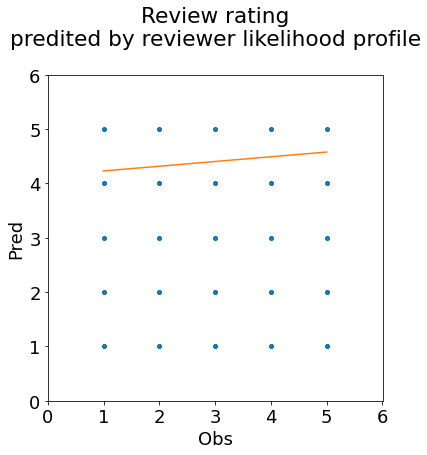

In [644]:
from matplotlib import pyplot as plt
xx = y
yy = pred_review_scores
plt.rcParams.update({'font.size':18})
plt.figure(figsize=[6,6]);
plt.plot(xx, yy, '.');
plt.xlabel('Obs');
plt.ylabel('Pred');
plt.xlim([0,6]);
plt.ylim([0,6]);
plt.plot(np.unique(xx), np.poly1d(np.polyfit(xx, yy, 1))(np.unique(xx)));
plt.title('Review rating\npredited by reviewer likelihood profile\n');

In [742]:
# now let's predict awesome vs. not awesome
# This is similar to the above, only we need posterior probabilities here
# to compute expected ratings for thresholding purposes. This requires
# classifier calibration and cross_val_predict with predict_proba. Otherwise
# similar to the above
from sklearn.calibration import CalibratedClassifierCV

t0 = time.time()

# GroupKFold gives you a KFold partitioner that abides by
# product labels so that products are only ever in a single
# fold
gkf = GroupKFold(n_splits=5)
cv = gkf.split(X, y, groups=lbl)

# alpha should be optimized
getLogLikProfiles = subjLogLikProfiles(laplaceSmooth=dict(alpha=0.2, d=5, mu='empirical'))
#getProfiles = subjProfile()

# NB isn't a great classifier but it's very fast
nb = GaussianNB()

calClf = CalibratedClassifierCV(nb)

# get subject class likelihood profiles, convert to log likelihood, convert reviews
# to products (sum log likelihoods, average ratings and threshold for awesome),
# then classify ratings based on sum of log likelihoods (i.e. product of likelihoods)
# GaussianNB should automatically apply empirical class priors
reviewClf = Pipeline([('getLogLikProfiles', getLogLikProfiles), ('normalize',lik2PostProb()), ('clf', calClf)])

pred_review_rating = cross_val_predict(reviewClf, X, y, cv=cv, method='predict_proba', n_jobs=5)

t1 = time.time()
print(t1-t0)

583.6307857036591


In [777]:
# computes expected rating based on probability of each class label
def expRating(prob):
    n,m = np.shape(prob)
    values = [1,2,3,4,5]
    values = np.tile(values,n).reshape(n,m)
    exp_val = np.sum(np.multiply(prob, values), axis=1)
    return exp_val

In [788]:
pred_review_rating = expRating(prob_review_rating)
pred_awesome = pred_review_rating > 4.5
obs_awesome = y > 4.5

In [779]:
from sklearn.metrics import classification_report

report = classification_report(obs_awesome, pred_awesome)
print('Awesome Review Predicted by Subject Profile')
print(report)
report = classification_report(obs_awesome, np.random.permutation(pred_awesome))
print('Null Prediction')
print(report)

Awesome Review Predicted by Subject Profile
              precision    recall  f1-score   support

       False       0.47      0.32      0.38   2787787
        True       0.69      0.81      0.74   5210560

    accuracy                           0.64   7998347
   macro avg       0.58      0.57      0.56   7998347
weighted avg       0.62      0.64      0.62   7998347

Null Prediction
              precision    recall  f1-score   support

       False       0.35      0.24      0.28   2787787
        True       0.65      0.76      0.70   5210560

    accuracy                           0.58   7998347
   macro avg       0.50      0.50      0.49   7998347
weighted avg       0.55      0.58      0.56   7998347



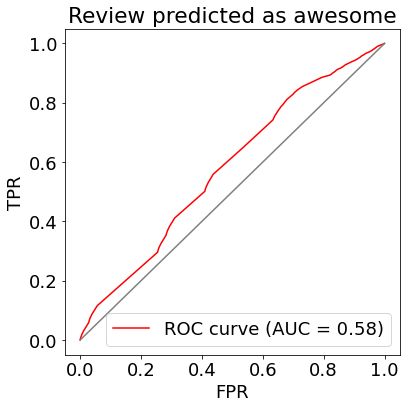

In [789]:
from sklearn.metrics import roc_curve, auc

review_fpr, review_tpr, _ = roc_curve(obs_awesome, pred_review_rating)
review_auc = auc(review_fpr, review_tpr)

xx = review_fpr
yy = review_tpr
plt.figure(figsize=[6,6])
plt.plot(xx, yy, label='ROC curve (AUC = %0.2f)' % review_auc, color='red')
plt.plot([0,1],[0,1],color='gray')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Review predicted as awesome');
plt.legend(loc='lower right')
plt.show()

In [781]:
# this is both the expected rating given the average 
# review probabilities, and the average of the review's
# expected ratings
prob_prod_rating, new_lbl = avgByLbl(prob_review_rating, lbl)
pred_prod_rating = expRating(prob_prod_rating)
pred_prod_awesome = pred_prod_rating > 4.5

obs_rating, new_lbl = avgByLbl(y, lbl)
obs_awesome = obs_rating > 4.5

In [785]:
from sklearn.metrics import classification_report

report = classification_report(obs_awesome, pred_prod_awesome)
print('Awesome Product Prediction by Subject Profile')
print(report)
report = classification_report(obs_awesome, np.random.permutation(pred_prod_awesome))
print('Null Prediction')
print(report)

Awesome Product Prediction by Subject Profile
              precision    recall  f1-score   support

       False       0.68      0.34      0.46     55197
        True       0.35      0.69      0.47     28552

    accuracy                           0.46     83749
   macro avg       0.52      0.52      0.46     83749
weighted avg       0.57      0.46      0.46     83749

Null Prediction
              precision    recall  f1-score   support

       False       0.66      0.33      0.44     55197
        True       0.34      0.67      0.45     28552

    accuracy                           0.45     83749
   macro avg       0.50      0.50      0.45     83749
weighted avg       0.55      0.45      0.44     83749



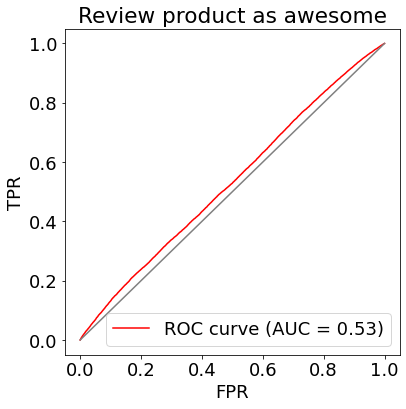

In [787]:
from sklearn.metrics import roc_curve, auc

prod_fpr, prod_tpr, _ = roc_curve(obs_awesome, pred_prod_rating)
prod_auc = auc(prod_fpr, prod_tpr)

xx = prod_fpr
yy = prod_tpr
plt.figure(figsize=[6,6])
plt.plot(xx, yy, label='ROC curve (AUC = %0.2f)' % prod_auc, color='red')
plt.plot([0,1],[0,1],color='gray')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Review product as awesome');
plt.legend(loc='lower right')
plt.show()